In [0]:
# Library Dependencies

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

import os
import shutil
import time
import re
import sys
import skimage.io as io

import random

from PIL import Image

from torchvision import datasets, models, transforms

In [0]:
#constants
#the fraction of an image
#the object must occupy in order to 
#be considered prominent
PROMINENT_PERCENT_THRESHOLD = 0.1

MAX_PROMINENT_NUM = 4

In [0]:
# Download and Install COCO API

!git clone https://github.com/cocodataset/cocoapi.git
!cd cocoapi/PythonAPI; make; cp -r pycocotools /content/api

In [0]:
# Download and Unzip Dataset 

!rm -rf /coco
!mkdir /coco
!rm /content/train.zip
!rm /content/annotations.zip

!wget http://images.cocodataset.org/zips/train2014.zip
!unzip train2014.zip -d /coco
!mv /coco/train2014 /coco/train
!rm /content/train2014.zip

!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip annotations_trainval2014.zip -d /coco 
!rm /content/annotations_trainval2014.zip

In [0]:
# Download and Unzip Validation Dataset 

!rm -rf /coco
!mkdir /coco
!rm /content/val.zip
!rm /content/annotations.zip

!wget http://images.cocodataset.org/zips/val2014.zip
!unzip val2014.zip -d /coco
!mv /coco/val2014 /coco/val
!rm /content/val2014.zip

!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip annotations_trainval2014.zip -d /coco 
!rm /content/annotations_trainval2014.zip

In [0]:
import pycocotools

In [0]:
!mv /coco /content/coco

In [29]:
cocoData = torchvision.datasets.CocoDetection("/content/coco/train","/content/coco/annotations/instances_val2014.json",
                                             transform = transforms.ToTensor())

loading annotations into memory...
Done (t=7.73s)
creating index...
index created!


In [0]:
data_loader = torch.utils.data.DataLoader(cocoData, batch_size=32)

torch.Size([3, 360, 640])
[{'segmentation': [[376.97, 176.91, 398.81, 176.91, 396.38, 147.78, 447.35, 146.17, 448.16, 172.05, 448.16, 178.53, 464.34, 186.62, 464.34, 192.28, 448.97, 195.51, 447.35, 235.96, 441.69, 258.62, 454.63, 268.32, 462.72, 276.41, 471.62, 290.98, 456.25, 298.26, 439.26, 292.59, 431.98, 308.77, 442.49, 313.63, 436.02, 316.86, 429.55, 322.53, 419.84, 354.89, 402.04, 359.74, 401.24, 312.82, 370.49, 303.92, 391.53, 299.87, 391.53, 280.46, 385.06, 278.84, 381.01, 278.84, 359.17, 269.13, 373.73, 261.85, 374.54, 256.19, 378.58, 231.11, 383.44, 205.22, 385.87, 192.28, 373.73, 184.19]], 'area': 12190.44565, 'iscrowd': 0, 'image_id': 391895, 'bbox': [359.17, 146.17, 112.45, 213.57], 'category_id': 4, 'id': 151091}, {'segmentation': [[352.55, 146.82, 353.61, 137.66, 356.07, 112.66, 357.13, 94.7, 357.13, 84.49, 363.12, 73.92, 370.16, 68.64, 370.16, 66.53, 368.4, 63.71, 368.05, 54.56, 361.0, 53.85, 356.07, 50.33, 356.43, 46.46, 364.17, 42.23, 369.1, 35.89, 371.22, 30.96, 376.

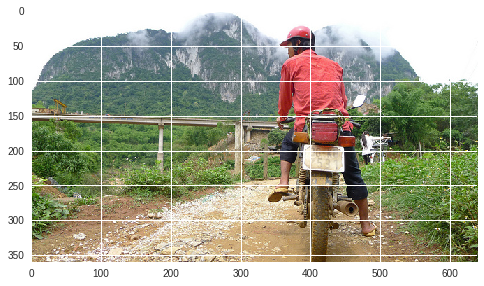

In [38]:
datapoint = cocoData[0]
image, target = datapoint
print(image.shape)
img = np.transpose(image, [1,2,0])
print(target)

plt.imshow(img)


In [110]:
cats = (cocoData.coco).loadCats((cocoData.coco).getCatIds())

for cat in cats:
  print(cat['name'])
  #print("Super Catergories: ")
  #print(cat['supercategory'])

person
bicycle
car
motorcycle
airplane
bus
train
truck
boat
traffic light
fire hydrant
stop sign
parking meter
bench
bird
cat
dog
horse
sheep
cow
elephant
bear
zebra
giraffe
backpack
umbrella
handbag
tie
suitcase
frisbee
skis
snowboard
sports ball
kite
baseball bat
baseball glove
skateboard
surfboard
tennis racket
bottle
wine glass
cup
fork
knife
spoon
bowl
banana
apple
sandwich
orange
broccoli
carrot
hot dog
pizza
donut
cake
chair
couch
potted plant
bed
dining table
toilet
tv
laptop
mouse
remote
keyboard
cell phone
microwave
oven
toaster
sink
refrigerator
book
clock
vase
scissors
teddy bear
hair drier
toothbrush


In [0]:
#returns the img dictionary and corresponding annotation id dictionary 
#containing images of
#the classes of interest
def generateSelImgDict():
  #the categories ids interest
  #they have a sueprcategory of 
  #person, vehicle or animal
  catIds_ = []
  imgIds = []
  annIds = []
  annDict = []
  
  for cat in cats:
    if cat['supercategory'] == 'person' or cat['supercategory']=='animal' or cat['supercategory']=='vehicle':
        catId = cocoData.coco.getCatIds(catNms = cat['name'])
        imgIdVec = (cocoData.coco).getImgIds(catIds=catId)
      
        for item in imgIdVec:
          imgIds.append(item)
          #the ids for the annotation for this image, but only for the category of
          #interest
          #print(cocoData.coco.getAnnIds(imgIds=item, catIds = catId, iscrowd = None))
          annId = cocoData.coco.getAnnIds(imgIds = item, catIds=catId, iscrowd=None)
          annDict.append(cocoData.coco.loadAnns(annId))
  #print(len(imgIds))

  #create dictionary of images of interest
  imgDict = (cocoData.coco).loadImgs(imgIds)
  
  return imgDict,annDict


In [0]:
imgDict,annDict = generateSelImgDict()

Height is: 431, Width is: 640


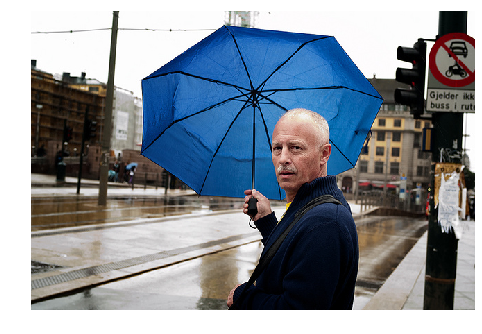

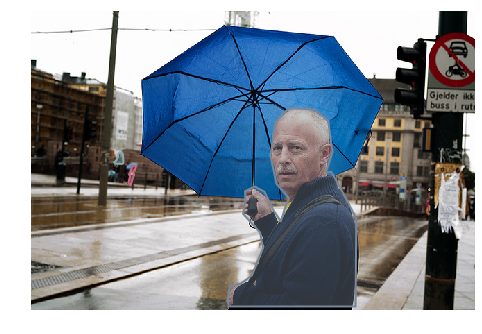

In [140]:
#Code adapted from:
#https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb
#example image from those chosen

#example image
imgInd = 130

img  = imgDict[imgInd]
print("Height is: {}, Width is: {}".format(img['height'], img['width']))
I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

#mask of image
plt.imshow(I); 
plt.axis('off')
cocoData.coco.showAnns(annDict[imgInd])


(-0.5, 639.5, 430.5, -0.5)

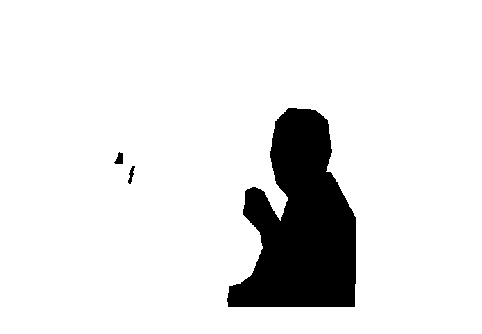

In [148]:
#bit mask for objects in image
#(objects of the category of interest)
anns = annDict[imgInd]
mask = cocoData.coco.annToMask(anns[0])

#create conglomerate mask over all objects in image
for i in range(len(anns)):
  mask = mask | cocoData.coco.annToMask(anns[i])

plt.imshow(mask); plt.axis('off')

In [161]:
print(mask)
mask_ = np.array(mask, dtype = 'float64')
print(mask_)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
#extract masked objects
#returns modified image
def extractWithMask(img,mask):
  mask_ = np.array(mask)
  
  #reshape to give 3rd axis for broadcasting
  #to the 3 channels
  mask_ = np.expand_dims(mask_, axis = 2)
  img_ = np.array(img)
  
  modified_image = img_*mask_
  
  return modified_image

(-0.5, 639.5, 430.5, -0.5)

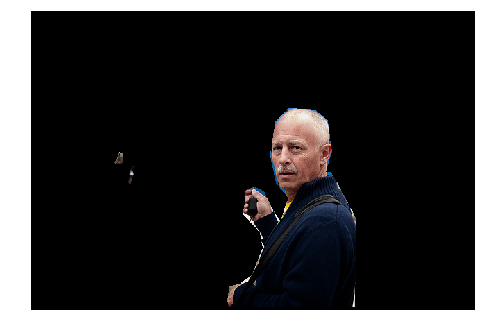

In [165]:
modified_img = extractWithMask(I, mask)
plt.imshow(modified_img)
plt.axis('off')

In [0]:
#given a single object's mask
#finds the percent of image that
#object occupies
def getPercentMask(obj_mask):
  num_occ= 0.0
  num_occ += (obj_mask != 0).sum()
  num_tot = sum(len(item) for item in obj_mask)
  
  return num_occ/num_tot



In [0]:
#given annotations for object
#creates a mask of only up to 4 prominent objects
#in the image
def genBinaryProminentMask(anns):
  mask = np.zeros(np.array(cocoData.coco.annToMask(anns[0])).shape)
  
  count = 0
  
  #create conglomerate mask over all objects in image
  for i in range(len(anns)):
    #if we get enough prominent objects in the image
    if (count == MAX_PROMINENT_NUM):
      break;
    
    #extract the mask corresponding to the annotation
    obj_mask = cocoData.coco.annToMask(anns[i])
    
    #compute the percentage (fraction) of image occupied
    #by the mask
    percent = getPercentMask(obj_mask)
    
    #only add if the percent is above some threshold 
    if (percent >= PROMINENT_PERCENT_THRESHOLD):
      mask = np.clip(mask + obj_mask, a_min =0, a_max =1)
      count+=1
      
  return mask

(-0.5, 639.5, 430.5, -0.5)

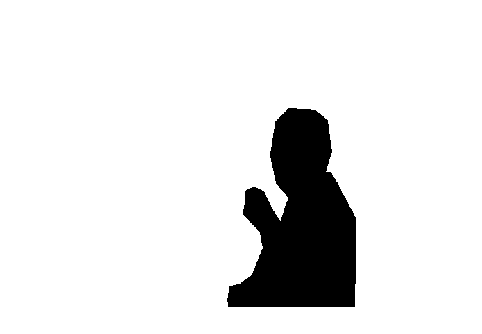

In [225]:
#test the code above on the img before
#only the man's object should be extracted in the mask now
mask_modified = genBinaryProminentMask(annDict[imgInd])
#print(mask_modified)
plt.imshow(mask_modified); plt.axis('off')

In [0]:
#given an img, crops and resizes it
#to be resize_dim by resize_dim
#fixes aspect ratio by padding to square
def crop_resize_square(img, resize_dim=224):
  img = np.array(img)
  #turn img into a PIL img
  im_pil = Image.fromarray(img, 'RGB')
 
  #to make square, choose dimension for padding first
  #side_len = max(height, width, resize_dim)
  
  #maintain aspect ratio and reduce to a dimension of resize_dim
  size = (resize_dim, resize_dim)
  
  im = im_pil.copy()
  im.thumbnail(size,Image.ANTIALIAS)
  w,h = im.size
  
  #create new image with black background
  square_im = Image.new('RGB', (resize_dim, resize_dim), (0,0,0))
  
  #paste in the original image to the square shaped one
  square_im.paste(im, (int((resize_dim-w)/2), int((resize_dim-h)/2)))
  
  return np.array(square_im)

(-0.5, 223.5, 223.5, -0.5)

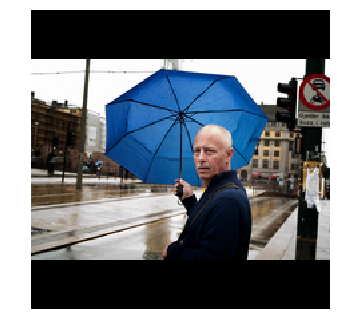

In [317]:
im =crop_resize_square(I)
plt.imshow(im); plt.axis('off')

In [0]:
#given the img and annotation dictionaries
#removes and cleans the data
#so that only those images with
#prominent objects remain

#returns the cleaned images, and their masks
#as targets in a tuple called data
#
def data_parse_prominent(imgDict, annDict, size):
  
  data = []
  
  count = 0
  
  #randomly shuffle indices to 
  #acces different images
  ind = np.arange(len(imgDict))
  random.shuffle(ind)
  
  for i in ind:
    
    #stop when size is reached
    if(count == size):
      break
      
    #generate prominent mask for object:
    mask = genBinaryProminentMask(annDict[i])
    
    #if entire mask is 0
    #there were no prominent objects in the mask
    #we only wish to add prominent objects
    if np.sum(mask)!=0:
      imgInf = imgDict[i]
      img = io.imread(imgInf['coco_url'])
      img = crop_resize_square(img)
      data.append((img, mask))
      count+=1
      
  if (count != size):
    print("Not enough data for size requested")
    
  return data

In [0]:
data = data_parse_prominent(imgDict, annDict,20)

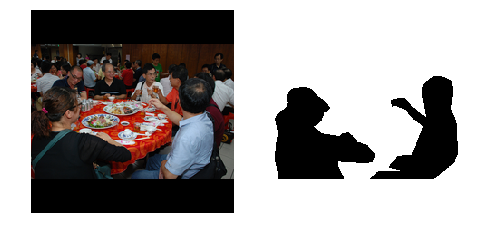

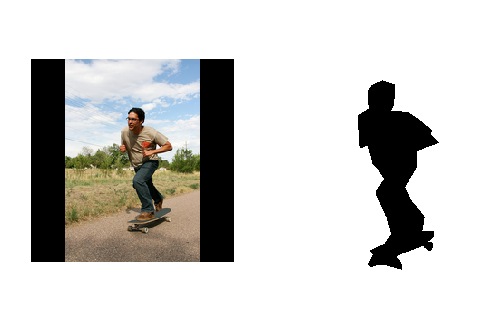

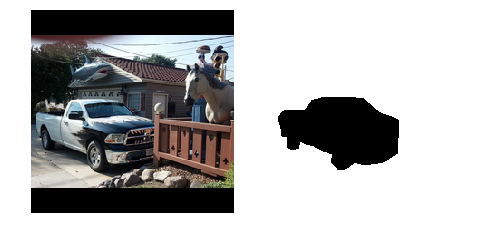

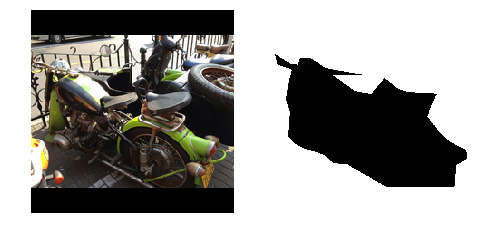

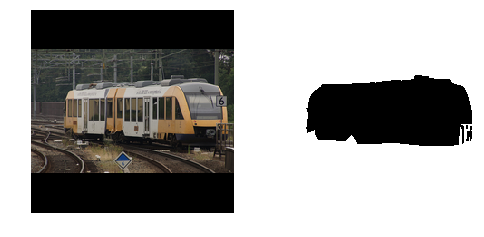

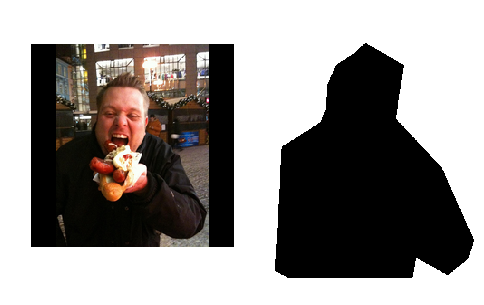

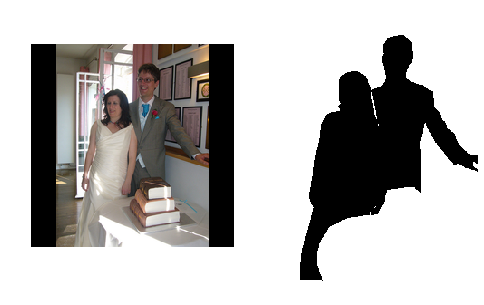

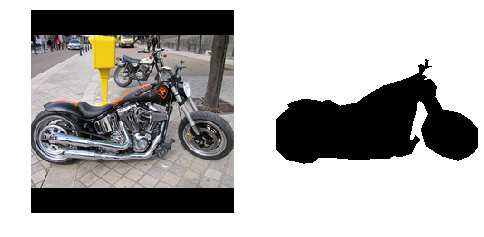

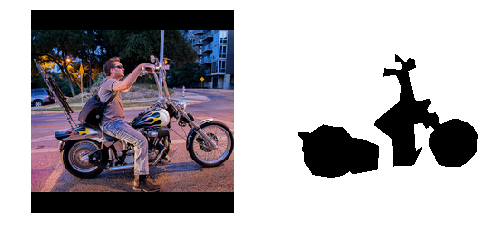

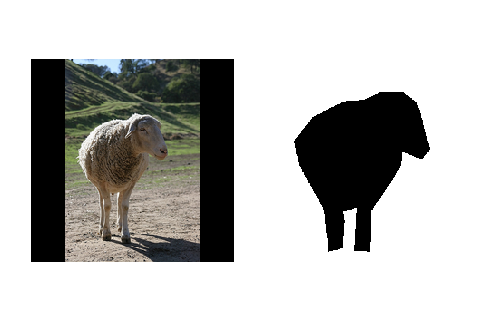

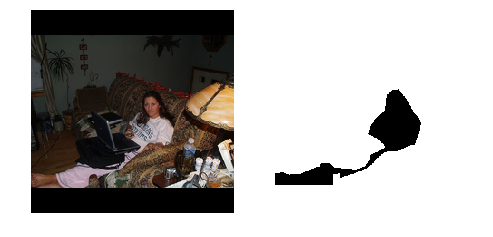

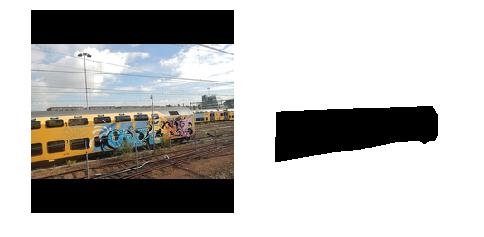

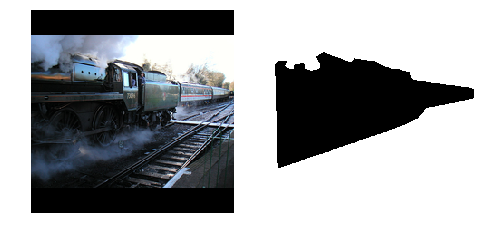

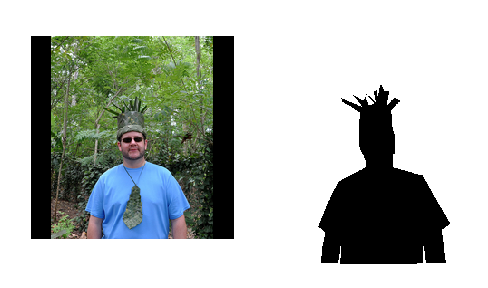

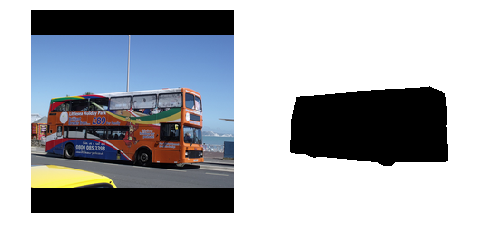

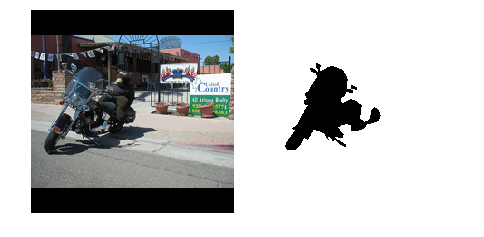

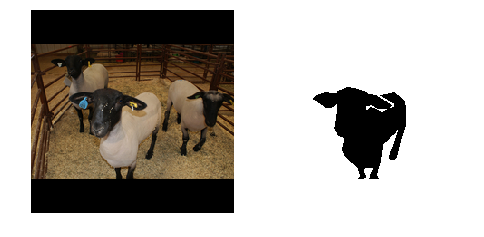

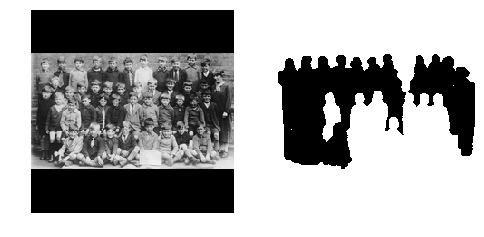

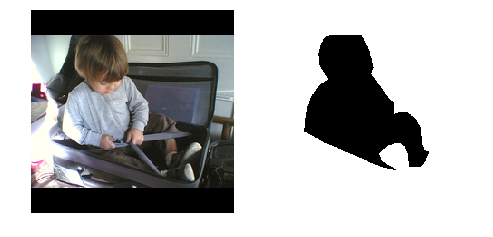

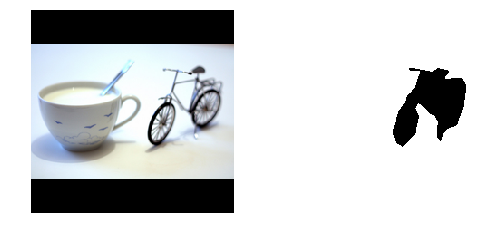

In [323]:
#visualization of data
for i,datapt in enumerate(data):
  img, target = datapt
  
 # print("Image: {}".format(i))
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(img);   plt.axis('off')
  
  plt.subplot(1,2,2)
  plt.imshow(target); plt.axis('off')
  
plt.show()

In [0]:
#create small dataset for training and validation
train = data_parse_prominent(imgDict, annDict,20)
valid = data_parse_prominent(imgDict, annDict, 10)

In [0]:
class extractNet_simple(nn.Module):
  
  def __init__(self):
    
  